# Process Chandak Data for TReconLM

Process the Chandak nanopore DNA storage dataset to match TReconLM format.

Uses existing utility functions from `src.utils.helper_functions`:
- `filter_string()` - Filter sequences to ACTG only
- `create_subclusters()` - Split large clusters and format examples

**Pipeline:**
1. Load clustered reads from selected experiments (117bp GT length)
2. Apply length filtering (100-140bp for high error tolerance)
3. Filter to ACTG characters only (using `filter_string`)
4. Group reads by cluster
5. Split by experiment: Train=[4,8,9,12], Val=[10], Test=[11]
6. Create subclusters using `create_subclusters` (max 10 reads for val/test)
7. Format as pipe-separated: `read1|read2|...|readN:ground_truth`
8. Save train.txt, val.txt, test.txt + supporting files

## 1. Setup and Imports

In [1]:
import os
import sys
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from collections import defaultdict
from Bio import SeqIO
from tqdm import tqdm

import wandb
# Setup paths
notebook_dir = Path.cwd()
project_root = (notebook_dir / ".." / "..").resolve()
sys.path.insert(0, str(project_root))

from src.utils.helper_functions import create_subclusters, filter_string

plt.style.use('default')
%matplotlib inline



## 2. Configuration

In [2]:
# Paths
BASE_DIR = Path('/workspaces/TReconLM/data/chandak')
PROCESSED_DATA_DIR = BASE_DIR / 'processed_data'
CLUSTERED_DATA_DIR = BASE_DIR / 'clustered_data_edit_dist_0'
OUTPUT_DIR = Path('/workspaces/TReconLM/data/chandak')

# Experiment selection (all have GT length = 117bp)
TRAIN_EXPS = [4, 8, 9, 12]
VAL_EXPS = [10]
TEST_EXPS = [11]
ALL_EXPS = TRAIN_EXPS + VAL_EXPS + TEST_EXPS

# Filtering parameters
GT_LENGTH = 117
MIN_READ_LENGTH = 100  # Allow up to 17bp deletions
MAX_READ_LENGTH = 140  # Allow up to 23bp insertions
MIN_CLUSTER_SIZE = 2   # Minimum reads per cluster
MAX_SUBCLUSTER_SIZE = 10  # For val/test splits

# Valid DNA characters
VALID_CHARS = set('ACTG')

print("Configuration:")
print(f"  Experiments: {ALL_EXPS}")
print(f"  Train: {TRAIN_EXPS}")
print(f"  Val: {VAL_EXPS}")
print(f"  Test: {TEST_EXPS}")
print(f"  GT length: {GT_LENGTH}bp")
print(f"  Read length range: {MIN_READ_LENGTH}-{MAX_READ_LENGTH}bp")
print(f"  Min cluster size: {MIN_CLUSTER_SIZE}")
print(f"  Max subcluster size: {MAX_SUBCLUSTER_SIZE}")

Configuration:
  Experiments: [4, 8, 9, 12, 10, 11]
  Train: [4, 8, 9, 12]
  Val: [10]
  Test: [11]
  GT length: 117bp
  Read length range: 100-140bp
  Min cluster size: 2
  Max subcluster size: 10


## 3. Load Clustering Results

In [3]:
def load_clustering_results(exp_id):
    """
    Load clustering results for an experiment.
    """
    results_file = CLUSTERED_DATA_DIR / f'experiment_{exp_id}' / 'clustering_results.csv'
    df = pd.read_csv(results_file)
    return df

# Load clustering results for all selected experiments
clustering_data = {}

print("Loading clustering results...\n")
for exp_id in ALL_EXPS:
    df = load_clustering_results(exp_id)
    clustering_data[exp_id] = df
    
    # Filter to mapped reads only
    mapped = df[df['status'].isin(['mapped', 'mapped_ambiguous'])]
    
    print(f"Experiment {exp_id}:")
    print(f"  Total reads: {len(df):,}")
    print(f"  Mapped reads: {len(mapped):,} ({100*len(mapped)/len(df):.1f}%)")
    print(f"  Unmapped reads: {len(df[df['status']=='unmapped']):,}")
    print(f"  Unique GTs: {df[df['gt_idx'] != -1]['gt_idx'].nunique()}")
    print()

print(f"Loaded clustering results for {len(clustering_data)} experiments")

Loading clustering results...

Experiment 4:
  Total reads: 149,622
  Mapped reads: 60,993 (40.8%)
  Unmapped reads: 88,629
  Unique GTs: 815

Experiment 8:
  Total reads: 243,729
  Mapped reads: 94,760 (38.9%)
  Unmapped reads: 148,969
  Unique GTs: 733

Experiment 9:
  Total reads: 188,004
  Mapped reads: 84,000 (44.7%)
  Unmapped reads: 104,004
  Unique GTs: 752

Experiment 12:
  Total reads: 251,343
  Mapped reads: 111,446 (44.3%)
  Unmapped reads: 139,897
  Unique GTs: 815

Experiment 10:
  Total reads: 122,106
  Mapped reads: 53,938 (44.2%)
  Unmapped reads: 68,168
  Unique GTs: 877

Experiment 11:
  Total reads: 131,086
  Mapped reads: 50,776 (38.7%)
  Unmapped reads: 80,310
  Unique GTs: 815

Loaded clustering results for 6 experiments


## 4. Load Ground Truth Sequences

In [4]:
def load_gt_sequences(exp_id):
    """
    Load ground truth sequences for an experiment.
    Returns: dict mapping gt_idx -> sequence
    """
    gt_file = PROCESSED_DATA_DIR / f'experiment_{exp_id}' / 'gt.fa'
    gt_dict = {}
    
    for idx, record in enumerate(SeqIO.parse(gt_file, 'fasta')):
        gt_dict[idx] = str(record.seq)
    
    return gt_dict

# Load GT sequences for all experiments
gt_sequences = {}

print("Loading ground truth sequences...\n")
for exp_id in ALL_EXPS:
    gt_dict = load_gt_sequences(exp_id)
    gt_sequences[exp_id] = gt_dict
    
    lengths = [len(seq) for seq in gt_dict.values()]
    print(f"Experiment {exp_id}:")
    print(f"  Num GTs: {len(gt_dict)}")
    print(f"  GT lengths: {min(lengths)}-{max(lengths)}bp (mean: {np.mean(lengths):.1f}bp)")
    print()

total_gts = sum(len(gt_dict) for gt_dict in gt_sequences.values())
print(f"Total GTs across all experiments: {total_gts}")

Loading ground truth sequences...

Experiment 4:
  Num GTs: 815
  GT lengths: 117-117bp (mean: 117.0bp)

Experiment 8:
  Num GTs: 733
  GT lengths: 117-117bp (mean: 117.0bp)

Experiment 9:
  Num GTs: 752
  GT lengths: 117-117bp (mean: 117.0bp)

Experiment 12:
  Num GTs: 815
  GT lengths: 117-117bp (mean: 117.0bp)

Experiment 10:
  Num GTs: 877
  GT lengths: 117-117bp (mean: 117.0bp)

Experiment 11:
  Num GTs: 815
  GT lengths: 117-117bp (mean: 117.0bp)

Total GTs across all experiments: 4807


## 5. Load and Filter Noisy Reads

In [5]:
def load_and_filter_reads(exp_id):
    """
    Load noisy reads for an experiment and apply filtering.
    Uses filter_string from helper_functions to keep only ACTG characters.
    Returns: dict mapping read_id -> filtered_sequence
    """
    reads_file = PROCESSED_DATA_DIR / f'experiment_{exp_id}' / 'reads.fastq'
    
    reads_dict = {}
    total_reads = 0
    filtered_out_length = 0
    filtered_out_chars = 0
    
    for record in SeqIO.parse(reads_file, 'fastq'):
        total_reads += 1
        original_seq = str(record.seq)
        
        # Use helper function to filter to ACTG only
        filtered_seq = filter_string(original_seq)
        
        if len(filtered_seq) != len(original_seq):
            filtered_out_chars += 1
        
        # Check length is within range
        if MIN_READ_LENGTH <= len(filtered_seq) <= MAX_READ_LENGTH:
            reads_dict[record.id] = filtered_seq
        else:
            filtered_out_length += 1
    
    return reads_dict, total_reads, filtered_out_length, filtered_out_chars

# Load and filter reads for all experiments
reads_data = {}
filter_stats = {}

print("Loading and filtering noisy reads (using filter_string from helper_functions)...\n")
for exp_id in tqdm(ALL_EXPS, desc="Loading experiments"):
    reads_dict, total, filtered_len, filtered_chars = load_and_filter_reads(exp_id)
    reads_data[exp_id] = reads_dict
    filter_stats[exp_id] = {
        'total': total,
        'kept': len(reads_dict),
        'filtered_length': filtered_len,
        'filtered_chars': filtered_chars
    }

print("\nFiltering statistics:")
print("="*70)
for exp_id in ALL_EXPS:
    stats = filter_stats[exp_id]
    print(f"Experiment {exp_id}:")
    print(f"  Total reads: {stats['total']:,}")
    print(f"  Kept: {stats['kept']:,} ({100*stats['kept']/stats['total']:.1f}%)")
    print(f"  Filtered (length): {stats['filtered_length']:,}")
    print(f"  Filtered (non-ACTG chars): {stats['filtered_chars']:,}")
    print()

total_kept = sum(stats['kept'] for stats in filter_stats.values())
total_original = sum(stats['total'] for stats in filter_stats.values())
print(f"Total reads kept: {total_kept:,} / {total_original:,} ({100*total_kept/total_original:.1f}%)")

Loading and filtering noisy reads (using filter_string from helper_functions)...



Loading experiments: 100%|██████████| 6/6 [00:17<00:00,  2.95s/it]


Filtering statistics:
Experiment 4:
  Total reads: 149,622
  Kept: 133,839 (89.5%)
  Filtered (length): 15,783
  Filtered (non-ACTG chars): 0

Experiment 8:
  Total reads: 243,729
  Kept: 210,261 (86.3%)
  Filtered (length): 33,468
  Filtered (non-ACTG chars): 0

Experiment 9:
  Total reads: 188,004
  Kept: 173,692 (92.4%)
  Filtered (length): 14,312
  Filtered (non-ACTG chars): 0

Experiment 12:
  Total reads: 251,343
  Kept: 225,740 (89.8%)
  Filtered (length): 25,603
  Filtered (non-ACTG chars): 0

Experiment 10:
  Total reads: 122,106
  Kept: 102,546 (84.0%)
  Filtered (length): 19,560
  Filtered (non-ACTG chars): 0

Experiment 11:
  Total reads: 131,086
  Kept: 121,352 (92.6%)
  Filtered (length): 9,734
  Filtered (non-ACTG chars): 0

Total reads kept: 967,430 / 1,085,890 (89.1%)


## 6. Group Reads by Cluster

In [6]:
def create_clusters(exp_id, clustering_df, reads_dict, gt_dict):
    """
    Create clusters by grouping reads to their GT sequences.
    
    Returns: list of dicts with {'gt_seq': str, 'reads': [str, ...]}
    """
    # Filter to mapped reads only
    mapped_df = clustering_df[clustering_df['status'].isin(['mapped', 'mapped_ambiguous'])].copy()
    
    # Group by gt_idx
    clusters = []
    
    for gt_idx, group in mapped_df.groupby('gt_idx'):
        # Get GT sequence
        if gt_idx not in gt_dict:
            continue
        
        gt_seq = gt_dict[gt_idx]
        
        # Get read sequences (only those that passed filtering)
        cluster_reads = []
        for read_id in group['read_id']:
            if read_id in reads_dict:
                cluster_reads.append(reads_dict[read_id])
        
        # Only keep clusters with at least MIN_CLUSTER_SIZE reads
        if len(cluster_reads) >= MIN_CLUSTER_SIZE:
            clusters.append({
                'gt_seq': gt_seq,
                'reads': cluster_reads
            })
    
    return clusters

# Create clusters for all experiments
all_clusters = {}

print("Creating clusters...\n")
for exp_id in ALL_EXPS:
    clusters = create_clusters(
        exp_id,
        clustering_data[exp_id],
        reads_data[exp_id],
        gt_sequences[exp_id]
    )
    all_clusters[exp_id] = clusters
    
    cluster_sizes = [len(c['reads']) for c in clusters]
    total_reads = sum(cluster_sizes)
    
    print(f"Experiment {exp_id}:")
    print(f"  Num clusters: {len(clusters)}")
    print(f"  Total reads: {total_reads:,}")
    print(f"  Cluster size: {np.mean(cluster_sizes):.1f} ± {np.std(cluster_sizes):.1f}")
    print(f"  Range: {min(cluster_sizes)}-{max(cluster_sizes)}")
    print()

total_clusters = sum(len(clusters) for clusters in all_clusters.values())
print(f"Total clusters: {total_clusters}")

Creating clusters...

Experiment 4:
  Num clusters: 815
  Total reads: 56,047
  Cluster size: 68.8 ± 44.5
  Range: 2-255

Experiment 8:
  Num clusters: 733
  Total reads: 84,280
  Cluster size: 115.0 ± 65.3
  Range: 5-433

Experiment 9:
  Num clusters: 752
  Total reads: 79,658
  Cluster size: 105.9 ± 58.7
  Range: 5-369

Experiment 12:
  Num clusters: 815
  Total reads: 102,021
  Cluster size: 125.2 ± 66.5
  Range: 5-486

Experiment 10:
  Num clusters: 877
  Total reads: 46,458
  Cluster size: 53.0 ± 33.2
  Range: 3-226

Experiment 11:
  Num clusters: 815
  Total reads: 48,174
  Cluster size: 59.1 ± 31.2
  Range: 4-246

Total clusters: 4807


## 7. Visualize Cluster Size Distributions

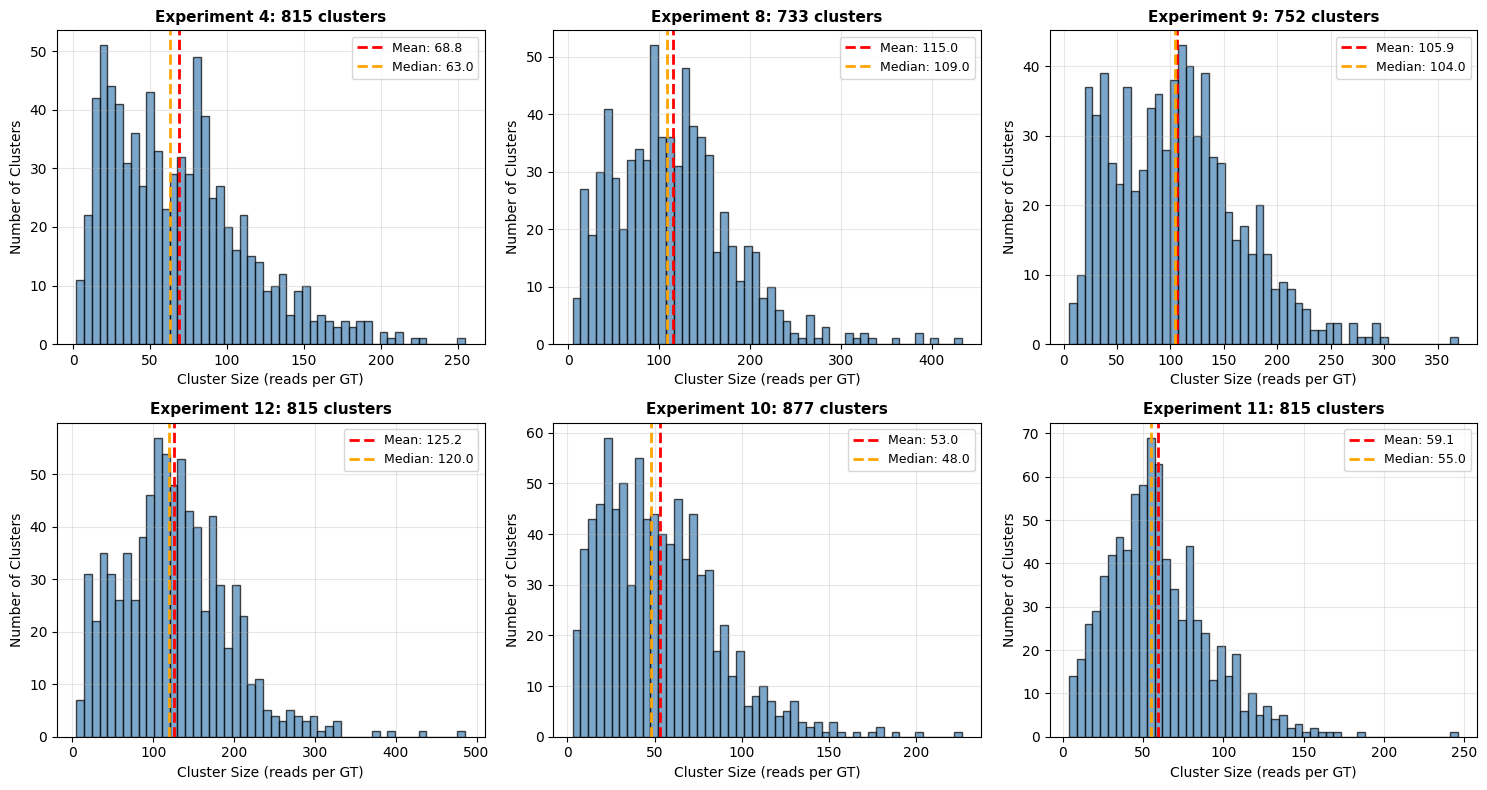

In [7]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for idx, exp_id in enumerate(ALL_EXPS):
    ax = axes[idx]
    cluster_sizes = [len(c['reads']) for c in all_clusters[exp_id]]
    
    ax.hist(cluster_sizes, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
    ax.axvline(np.mean(cluster_sizes), color='red', linestyle='--', linewidth=2,
               label=f'Mean: {np.mean(cluster_sizes):.1f}')
    ax.axvline(np.median(cluster_sizes), color='orange', linestyle='--', linewidth=2,
               label=f'Median: {np.median(cluster_sizes):.1f}')
    
    ax.set_xlabel('Cluster Size (reads per GT)', fontsize=10)
    ax.set_ylabel('Number of Clusters', fontsize=10)
    ax.set_title(f'Experiment {exp_id}: {len(cluster_sizes)} clusters', 
                 fontsize=11, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Split by Experiment (Train/Val/Test)

In [8]:
# Assign clusters to splits based on experiment
train_clusters = []
val_clusters = []
test_clusters = []

for exp_id in TRAIN_EXPS:
    train_clusters.extend(all_clusters[exp_id])

for exp_id in VAL_EXPS:
    val_clusters.extend(all_clusters[exp_id])

for exp_id in TEST_EXPS:
    test_clusters.extend(all_clusters[exp_id])

print("Split Statistics:")
print("="*70)
print(f"Train:")
print(f"  Experiments: {TRAIN_EXPS}")
print(f"  Num clusters: {len(train_clusters)}")
print(f"  Total reads: {sum(len(c['reads']) for c in train_clusters):,}")
print()
print(f"Val:")
print(f"  Experiments: {VAL_EXPS}")
print(f"  Num clusters: {len(val_clusters)}")
print(f"  Total reads: {sum(len(c['reads']) for c in val_clusters):,}")
print()
print(f"Test:")
print(f"  Experiments: {TEST_EXPS}")
print(f"  Num clusters: {len(test_clusters)}")
print(f"  Total reads: {sum(len(c['reads']) for c in test_clusters):,}")

Split Statistics:
Train:
  Experiments: [4, 8, 9, 12]
  Num clusters: 3115
  Total reads: 322,006

Val:
  Experiments: [10]
  Num clusters: 877
  Total reads: 46,458

Test:
  Experiments: [11]
  Num clusters: 815
  Total reads: 48,174


## 9. Create Subclusters (Val/Test only)

In [9]:
# Use create_subclusters from helper_functions
# Note: This function returns formatted examples directly as strings

# Prepare data for train (no subclustering - max_reads=None)
train_clusters_list = [c['reads'] for c in train_clusters]
train_gts = [c['gt_seq'] for c in train_clusters]

# Prepare data for val (with subclustering - max_reads=10, truncate=False)
val_clusters_list = [c['reads'] for c in val_clusters]
val_gts = [c['gt_seq'] for c in val_clusters]

# Prepare data for test (with subclustering - max_reads=10, truncate=False)
test_clusters_list = [c['reads'] for c in test_clusters]
test_gts = [c['gt_seq'] for c in test_clusters]

print("Creating subclusters using helper_functions.create_subclusters()...\n")

# Train: No subclustering (max_reads=None keeps full clusters)
train_examples, train_cluster_sizes = create_subclusters(
    clusters=train_clusters_list,
    ground_truths=train_gts,
    max_reads=None,  # No subclustering for train
    truncate=False
)

# Val: With subclustering (max_reads=10, truncate=False splits large clusters)
val_examples, val_cluster_sizes = create_subclusters(
    clusters=val_clusters_list,
    ground_truths=val_gts,
    max_reads=MAX_SUBCLUSTER_SIZE,
    truncate=False  # Split large clusters into subclusters
)

# Test: With subclustering (max_reads=10, truncate=False splits large clusters)
test_examples, test_cluster_sizes = create_subclusters(
    clusters=test_clusters_list,
    ground_truths=test_gts,
    max_reads=MAX_SUBCLUSTER_SIZE,
    truncate=False  # Split large clusters into subclusters
)

print("Subcluster Statistics:")
print("="*70)
print(f"Train (no subclustering, max_reads=None):")
print(f"  Original clusters: {len(train_clusters)}")
print(f"  Examples: {len(train_examples)}")
print(f"  Avg reads per example: {np.mean(train_cluster_sizes):.1f}")
print(f"  Range: {min(train_cluster_sizes)}-{max(train_cluster_sizes)}")
print()
print(f"Val (with subclustering, max_reads={MAX_SUBCLUSTER_SIZE}):")
print(f"  Original clusters: {len(val_clusters)}")
print(f"  Subclustered examples: {len(val_examples)}")
print(f"  Avg reads per example: {np.mean(val_cluster_sizes):.1f}")
print(f"  Range: {min(val_cluster_sizes)}-{max(val_cluster_sizes)}")
print()
print(f"Test (with subclustering, max_reads={MAX_SUBCLUSTER_SIZE}):")
print(f"  Original clusters: {len(test_clusters)}")
print(f"  Subclustered examples: {len(test_examples)}")
print(f"  Avg reads per example: {np.mean(test_cluster_sizes):.1f}")
print(f"  Range: {min(test_cluster_sizes)}-{max(test_cluster_sizes)}")

Creating subclusters using helper_functions.create_subclusters()...

Subcluster Statistics:
Train (no subclustering, max_reads=None):
  Original clusters: 3115
  Examples: 3115
  Avg reads per example: 103.4
  Range: 2-486

Val (with subclustering, max_reads=10):
  Original clusters: 877
  Subclustered examples: 8212
  Avg reads per example: 5.6
  Range: 2-10

Test (with subclustering, max_reads=10):
  Original clusters: 815
  Subclustered examples: 8506
  Avg reads per example: 5.6
  Range: 2-10


## 10. Inspect Formatted Examples

In [10]:
# Examples are already formatted by create_subclusters()
# Format: read1|read2|...|readN:ground_truth

print("Formatted Examples:")
print("="*70)
print(f"Train: {len(train_examples):,} examples")
print(f"Val: {len(val_examples):,} examples")
print(f"Test: {len(test_examples):,} examples")
print()
print("Example format (first 3 from train):")
print("="*70)
for i, example in enumerate(train_examples[:3]):
    # Show truncated version for readability
    parts = example.split(':')
    reads_part = parts[0]
    gt_part = parts[1]
    
    reads = reads_part.split('|')
    print(f"\nExample {i+1}:")
    print(f"  Num reads: {len(reads)}")
    print(f"  First read: {reads[0][:50]}... (len={len(reads[0])})")
    if len(reads) > 1:
        print(f"  Second read: {reads[1][:50]}... (len={len(reads[1])})")
    print(f"  Ground truth: {gt_part[:50]}... (len={len(gt_part)})")

Formatted Examples:
Train: 3,115 examples
Val: 8,212 examples
Test: 8,506 examples

Example format (first 3 from train):

Example 1:
  Num reads: 104
  First read: GAGTTCGCATGTAAAGGGCAGGTGTTATCTAAATGTTAGGGCGAGCATCT... (len=121)
  Second read: GAGTTCGCATGTAAAGGCAGGTGTCTAAATGATAGGGCGAGCATTCATAT... (len=106)
  Ground truth: GAGTTCGCATGTAAAGGGCAGGTGTCTAAATGATAGGGCGAGCATCTGGC... (len=117)

Example 2:
  Num reads: 54
  First read: CCCTTAACAATAGTGGGAATCGGGGATAGGTGGAACTGGGCGCTATGCTC... (len=116)
  Second read: CTTAACAATAGTGAAATCAGGATAGGTGAACTGGGCGCTATGCTCTTACG... (len=109)
  Ground truth: CTTAACAATAGTGAATCAGGGGATAGGTGGAACTGGGCGCTATGCTCGCA... (len=117)

Example 3:
  Num reads: 70
  First read: CATGGCTAGTCAAAATACCCGAACTCTTGTCAGTAAGAACAGGGTCGTGG... (len=112)
  Second read: CATGGCTAGTCCAAAATACCCGAACTCTTTGTCAGTAAGAACGGGGCGTG... (len=114)
  Ground truth: CATGGCTAGTCCAAAATACCCGAACTCTTGTCAGTAAGAACGGGGTCGTG... (len=117)


## 11. Encode and Pad Test Set (for Inference)

In [14]:
# Create output directory if it doesn't exist
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print("Saving output files...")
print("="*70)

# 1. Save train.txt
train_file = OUTPUT_DIR / 'train.txt'
with open(train_file, 'w') as f:
    for example in train_examples:
        f.write(example + '\n')
print(f"✓ Saved train.txt: {len(train_examples):,} examples")

# 2. Save val.txt
val_file = OUTPUT_DIR / 'val.txt'
with open(val_file, 'w') as f:
    for example in val_examples:
        f.write(example + '\n')
print(f"✓ Saved val.txt: {len(val_examples):,} examples")

# 3. Save test.txt
test_file = OUTPUT_DIR / 'test.txt'
with open(test_file, 'w') as f:
    for example in test_examples:
        f.write(example + '\n')
print(f"✓ Saved test.txt: {len(test_examples):,} examples")

print()

# 4. Save reads.txt (test reads only, for evaluation)
# Format: reads separated by "==============================="
reads_file = OUTPUT_DIR / 'reads.txt'
with open(reads_file, 'w') as f:
    for example in test_examples:
        # Split example into reads and ground truth
        reads_part, gt_part = example.split(':')
        reads = reads_part.split('|')
        
        # Write reads separated by newlines
        for read in reads:
            f.write(read + '\n')
        
        # Write separator
        f.write('===============================\n')

print(f"✓ Saved reads.txt: test reads for evaluation")

# 5. Save ground_truth.txt (test GTs only, for evaluation)
# Format: one ground truth per line
gt_file = OUTPUT_DIR / 'ground_truth.txt'
with open(gt_file, 'w') as f:
    for example in test_examples:
        # Extract ground truth from example
        _, gt = example.split(':')
        f.write(gt + '\n')

print(f"✓ Saved ground_truth.txt: {len(test_examples):,} ground truths")

print()
print("All files saved successfully!")
print("="*70)
print(f"\nOutput directory: {OUTPUT_DIR}")
print(f"\nFiles created:")
print(f"\n  Training/Finetuning:")
print(f"    - train.txt ({len(train_examples):,} examples)")
print(f"    - val.txt ({len(val_examples):,} examples)")
print(f"    - test.txt ({len(test_examples):,} examples)")
print(f"\n  Inference (encoded tensors):")
print(f"    - test_x.pt (shape: {test_x.shape})")
print(f"    - test_y.pt (shape: {test_y.shape})")
print(f"\n  Evaluation (baseline methods):")
print(f"    - reads.txt (test reads)")
print(f"    - ground_truth.txt (test ground truths)")

Saving output files...
✓ Saved train.txt: 3,115 examples
✓ Saved val.txt: 8,212 examples
✓ Saved test.txt: 8,506 examples

✓ Saved reads.txt: test reads for evaluation
✓ Saved ground_truth.txt: 8,506 ground truths

All files saved successfully!

Output directory: /workspaces/TReconLM/data/chandak

Files created:

  Training/Finetuning:
    - train.txt (3,115 examples)
    - val.txt (8,212 examples)
    - test.txt (8,506 examples)

  Inference (encoded tensors):
    - test_x.pt (shape: torch.Size([8506, 1499]))
    - test_y.pt (shape: torch.Size([8506, 1499]))

  Evaluation (baseline methods):
    - reads.txt (test reads)
    - ground_truth.txt (test ground truths)


## 12. Save Output Files

In [12]:
# Compute detailed statistics
stats = {
    'dataset': 'chandak',
    'gt_length': GT_LENGTH,
    'read_length_range': [MIN_READ_LENGTH, MAX_READ_LENGTH],
    'min_cluster_size': MIN_CLUSTER_SIZE,
    'max_subcluster_size': MAX_SUBCLUSTER_SIZE,
    'train': {
        'experiments': TRAIN_EXPS,
        'num_original_clusters': len(train_clusters),
        'num_examples': len(train_examples),
        'num_unique_gts': len(set(ex.split(':')[1] for ex in train_examples)),
        'total_reads': sum(train_cluster_sizes),
        'avg_reads_per_example': np.mean(train_cluster_sizes),
        'median_reads_per_example': np.median(train_cluster_sizes),
        'min_reads_per_example': min(train_cluster_sizes),
        'max_reads_per_example': max(train_cluster_sizes),
    },
    'val': {
        'experiments': VAL_EXPS,
        'num_original_clusters': len(val_clusters),
        'num_examples': len(val_examples),
        'num_unique_gts': len(set(ex.split(':')[1] for ex in val_examples)),
        'total_reads': sum(val_cluster_sizes),
        'avg_reads_per_example': np.mean(val_cluster_sizes),
        'median_reads_per_example': np.median(val_cluster_sizes),
        'min_reads_per_example': min(val_cluster_sizes),
        'max_reads_per_example': max(val_cluster_sizes),
    },
    'test': {
        'experiments': TEST_EXPS,
        'num_original_clusters': len(test_clusters),
        'num_examples': len(test_examples),
        'num_unique_gts': len(set(ex.split(':')[1] for ex in test_examples)),
        'total_reads': sum(test_cluster_sizes),
        'avg_reads_per_example': np.mean(test_cluster_sizes),
        'median_reads_per_example': np.median(test_cluster_sizes),
        'min_reads_per_example': min(test_cluster_sizes),
        'max_reads_per_example': max(test_cluster_sizes),
    }
}

# Save statistics
stats_file = OUTPUT_DIR / 'dataset_stats.json'
with open(stats_file, 'w') as f:
    json.dump(stats, f, indent=2)

print("Dataset Statistics:")
print("="*70)
print(json.dumps(stats, indent=2))
print()
print(f"Saved: {stats_file}")

Dataset Statistics:
{
  "dataset": "chandak",
  "gt_length": 117,
  "read_length_range": [
    100,
    140
  ],
  "min_cluster_size": 2,
  "max_subcluster_size": 10,
  "train": {
    "experiments": [
      4,
      8,
      9,
      12
    ],
    "num_original_clusters": 3115,
    "num_examples": 3115,
    "num_unique_gts": 1673,
    "total_reads": 322006,
    "avg_reads_per_example": 103.37271268057785,
    "median_reads_per_example": 97.0,
    "min_reads_per_example": 2,
    "max_reads_per_example": 486
  },
  "val": {
    "experiments": [
      10
    ],
    "num_original_clusters": 877,
    "num_examples": 8212,
    "num_unique_gts": 877,
    "total_reads": 46119,
    "avg_reads_per_example": 5.616049683390161,
    "median_reads_per_example": 5.0,
    "min_reads_per_example": 2,
    "max_reads_per_example": 10
  },
  "test": {
    "experiments": [
      11
    ],
    "num_original_clusters": 815,
    "num_examples": 8506,
    "num_unique_gts": 815,
    "total_reads": 47898,
    "a

## 13. Final Summary Visualization

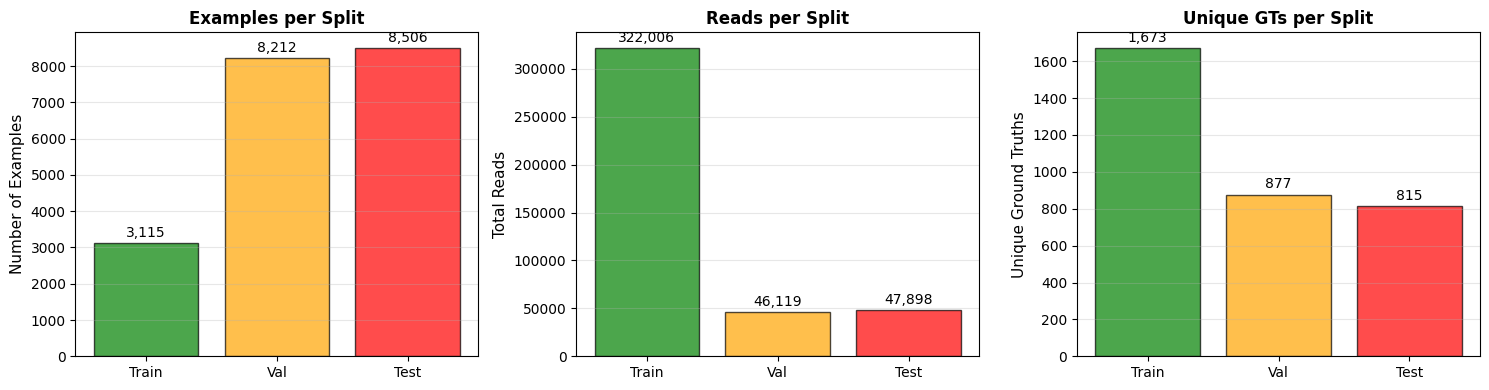


Processing complete!
Output directory: /workspaces/TReconLM/data/chandak

Files created:

For training/finetuning:
  - train.txt (3,115 examples)
  - val.txt (8,212 examples)
  - test.txt (8,506 examples)

For inference/evaluation:
  - test_x.pt (encoded & padded tensor inputs)
  - test_y.pt (encoded & padded tensor targets)
  - reads.txt (test reads only, for evaluation)
  - ground_truth.txt (test GTs only, for evaluation)

Metadata:
  - dataset_stats.json (detailed statistics)

Note: Uses global vocabulary from TReconLM/src/data_pkg/meta_nuc.pkl


In [13]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Bar chart of examples per split
ax = axes[0]
splits = ['Train', 'Val', 'Test']
counts = [
    stats['train']['num_examples'],
    stats['val']['num_examples'],
    stats['test']['num_examples']
]
ax.bar(splits, counts, edgecolor='black', alpha=0.7, color=['green', 'orange', 'red'])
ax.set_ylabel('Number of Examples', fontsize=11)
ax.set_title('Examples per Split', fontsize=12, fontweight='bold')
ax.grid(alpha=0.3, axis='y')
for i, count in enumerate(counts):
    ax.text(i, count + max(counts)*0.02, f'{count:,}', ha='center', fontsize=10)

# Bar chart of total reads per split
ax = axes[1]
reads = [
    stats['train']['total_reads'],
    stats['val']['total_reads'],
    stats['test']['total_reads']
]
ax.bar(splits, reads, edgecolor='black', alpha=0.7, color=['green', 'orange', 'red'])
ax.set_ylabel('Total Reads', fontsize=11)
ax.set_title('Reads per Split', fontsize=12, fontweight='bold')
ax.grid(alpha=0.3, axis='y')
for i, count in enumerate(reads):
    ax.text(i, count + max(reads)*0.02, f'{count:,}', ha='center', fontsize=10)

# Bar chart of unique GTs per split
ax = axes[2]
gts = [
    stats['train']['num_unique_gts'],
    stats['val']['num_unique_gts'],
    stats['test']['num_unique_gts']
]
ax.bar(splits, gts, edgecolor='black', alpha=0.7, color=['green', 'orange', 'red'])
ax.set_ylabel('Unique Ground Truths', fontsize=11)
ax.set_title('Unique GTs per Split', fontsize=12, fontweight='bold')
ax.grid(alpha=0.3, axis='y')
for i, count in enumerate(gts):
    ax.text(i, count + max(gts)*0.02, f'{count:,}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

print("\nProcessing complete!")
print("="*70)
print(f"Output directory: {OUTPUT_DIR}")
print(f"\nFiles created:")
print(f"\nFor training/finetuning:")
print(f"  - train.txt ({len(train_examples):,} examples)")
print(f"  - val.txt ({len(val_examples):,} examples)")
print(f"  - test.txt ({len(test_examples):,} examples)")
print(f"\nFor inference/evaluation:")
print(f"  - test_x.pt (encoded & padded tensor inputs)")
print(f"  - test_y.pt (encoded & padded tensor targets)")
print(f"  - reads.txt (test reads only, for evaluation)")
print(f"  - ground_truth.txt (test GTs only, for evaluation)")
print(f"\nMetadata:")
print(f"  - dataset_stats.json (detailed statistics)")
print(f"\nNote: Uses global vocabulary from TReconLM/src/data_pkg/meta_nuc.pkl")